# CLIP GRADCAM

Derived from https://colab.research.google.com/github/kevinzakka/clip_playground/blob/main/CLIP_GradCAM_Visualization.ipynb

In [ ]:
# %%capture
# %pip install ftfy regex tqdm matplotlib opencv-python scipy scikit-image
# %pip install git+https://github.com/openai/CLIP.git

In [4]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path
from src.utils.clip_grad_cam import *

In [2]:
import urllib.request
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import clip
from PIL import Image
from scipy.ndimage import filters
from torch import nn

In [51]:
clip_model = "RN101" #@param ["RN50", "RN101", "RN50x4", "RN50x16"]
saliency_layer = "layer4" #@param ["layer4", "layer3", "layer2", "layer1"]

blur = True #@param {type:"boolean"}

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


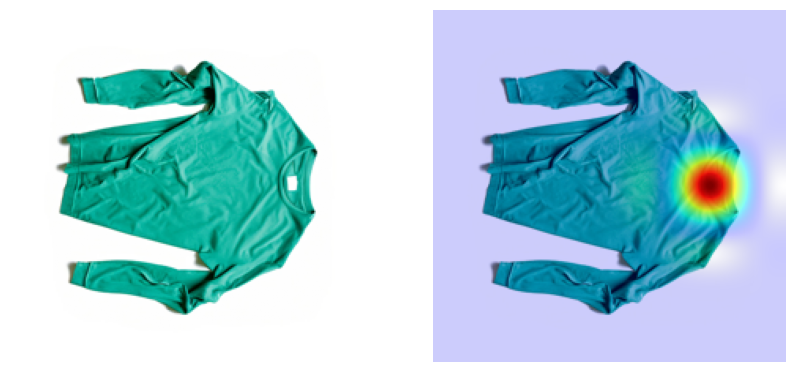

In [57]:
image_caption = 'a shirt' 

class_name = 'shirt'
relative_path = get_training_data_path('classifier', class_name)

image_path = relative_path + "/shirt_right.jpg"

image_input = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
image_np = load_image(image_path, model.visual.input_resolution)
text_input = clip.tokenize([image_caption]).to(device)

attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)

In [61]:
text = clip.tokenize(["a top body cloth", 'a lower body cloth']).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image_input, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs) 

Label probs: [[0.7607 0.2394]]
